In [11]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
from torch.optim import *

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [81]:
path = Path("/home/subhaditya/Desktop/Datasets/pokemon/")

In [82]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=64)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

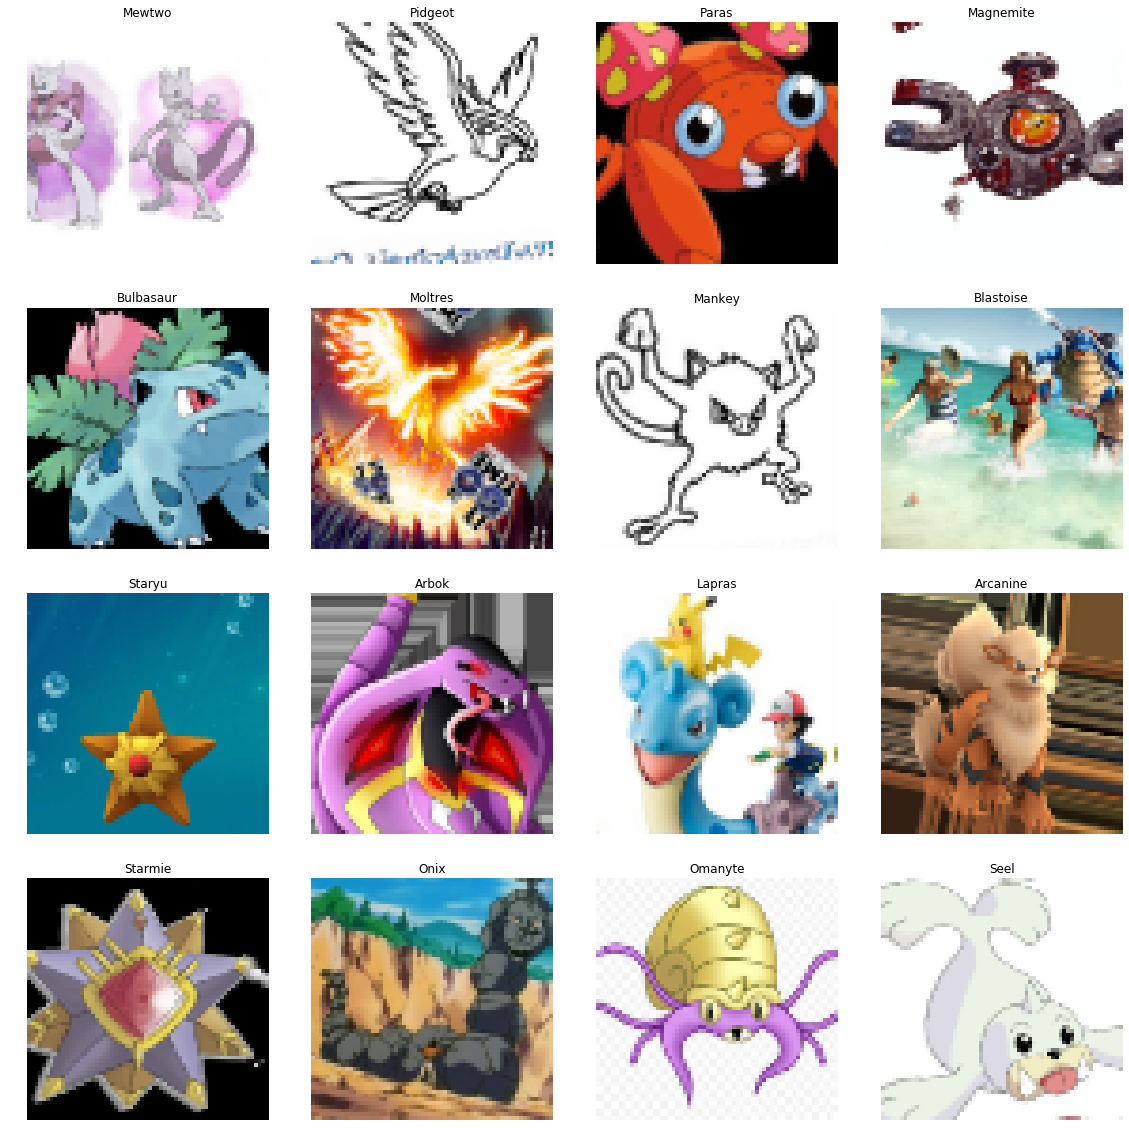

In [83]:
data.show_batch(4)

In [86]:
data.c

77

In [87]:
learn = None
gc.collect()

98

In [90]:
learn = cnn_learner(
    data, models.resnet50, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


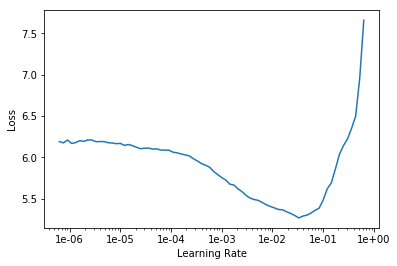

In [91]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

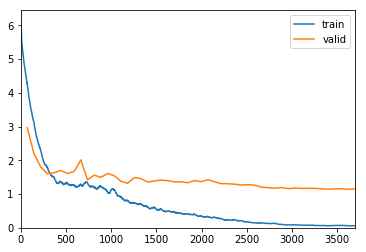

In [92]:
learn.unfreeze()
learn.fit_one_cycle(50, slice(1e-2), wd=1e-3)

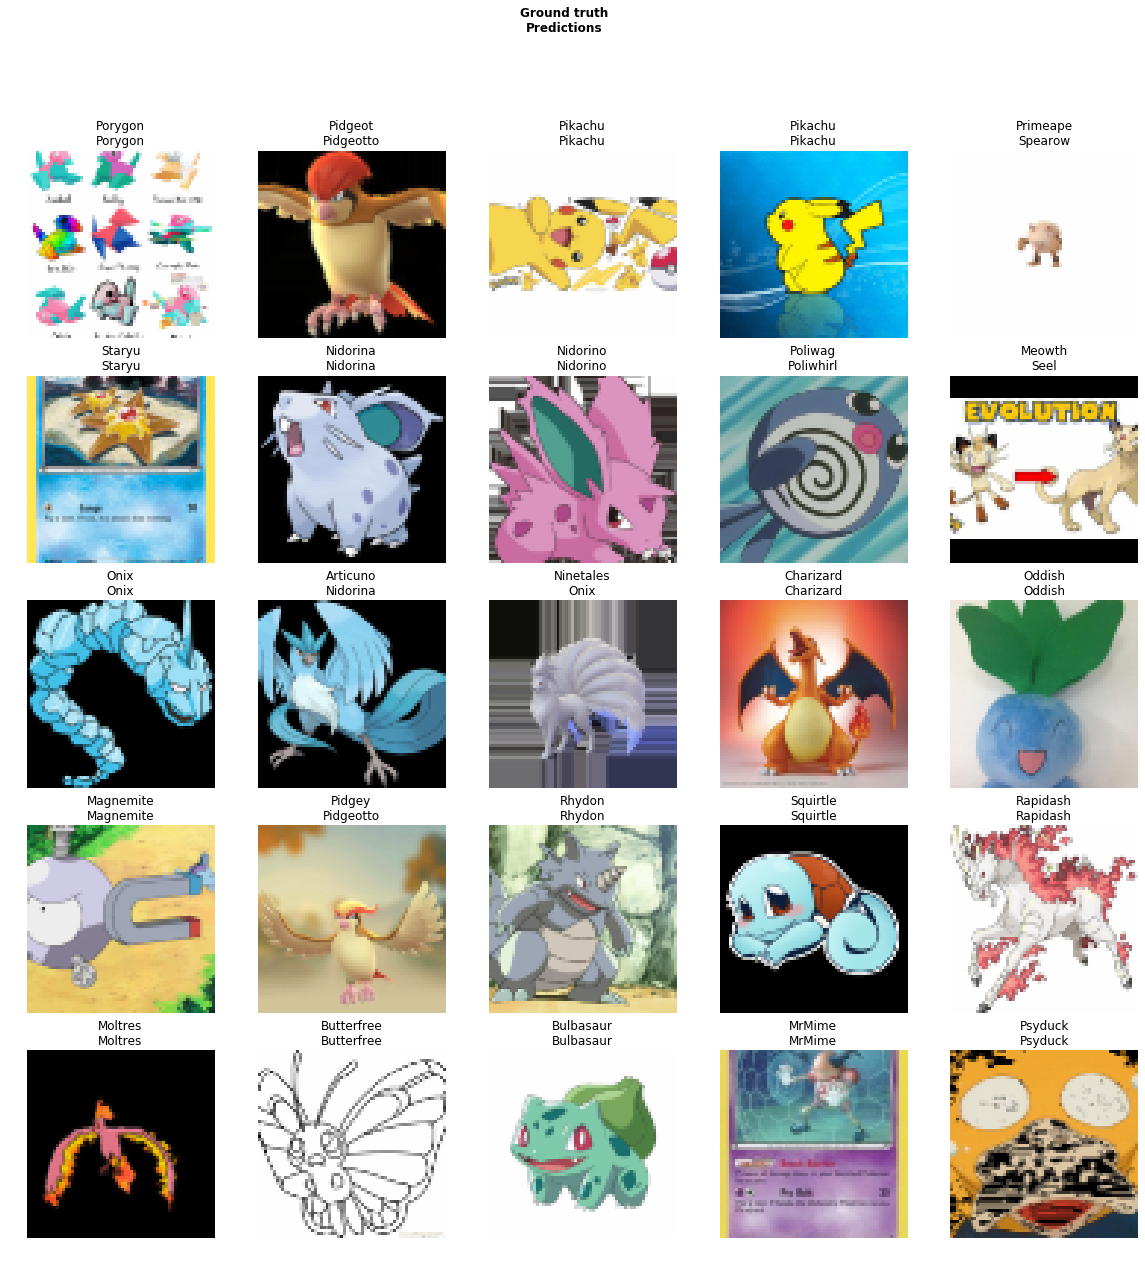

In [93]:
learn.show_results()

In [94]:
from fastai.callbacks.hooks import *

In [95]:
class SaveFeatures:
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))

    def remove(self):
        self.hook.remove()

In [96]:
learn.model[1][4]

Linear(in_features=4096, out_features=512, bias=True)

In [97]:
sf = SaveFeatures(learn.model[1][4])

In [98]:
data_big = data

In [99]:
_ = learn.get_preds(data_big.train_ds)
_ = learn.get_preds(DatasetType.Valid)

In [100]:
img_path = [
    str(x) for x in (list(data_big.train_ds.items) + list(data_big.valid_ds.items))
]
label = [
    data_big.classes[x]
    for x in (list(data_big.train_ds.y.items) + list(data_big.valid_ds.y.items))
]
label_id = [
    x for x in (list(data_big.train_ds.y.items) + list(data_big.valid_ds.y.items))
]

In [101]:
len(img_path), len(label), len(label_id)

(5961, 5961, 5961)

In [102]:
df_new = pd.DataFrame({"img_path": img_path, "label": label, "label_id": label_id})
df_new

img_path      label  label_id
0     /home/subhaditya/Desktop/Datasets/pokemon/Abra...       Abra         0
1     /home/subhaditya/Desktop/Datasets/pokemon/Abra...       Abra         0
2     /home/subhaditya/Desktop/Datasets/pokemon/Abra...       Abra         0
3     /home/subhaditya/Desktop/Datasets/pokemon/Abra...       Abra         0
4     /home/subhaditya/Desktop/Datasets/pokemon/Abra...       Abra         0
...                                                 ...        ...       ...
5956  /home/subhaditya/Desktop/Datasets/pokemon/Rapi...   Rapidash        57
5957  /home/subhaditya/Desktop/Datasets/pokemon/Lick...  Lickitung        15
5958  /home/subhaditya/Desktop/Datasets/pokemon/Slow...    Slowbro        69
5959  /home/subhaditya/Desktop/Datasets/pokemon/Ratt...    Rattata        59
5960  /home/subhaditya/Desktop/Datasets/pokemon/Pika...    Pikachu        47

[5961 rows x 3 columns]

In [103]:
array = np.array(sf.features)

x = array.tolist()

df_new["img_repr"] = x

df_new.head()

img_path label  label_id  \
0  /home/subhaditya/Desktop/Datasets/pokemon/Abra...  Abra         0   
1  /home/subhaditya/Desktop/Datasets/pokemon/Abra...  Abra         0   
2  /home/subhaditya/Desktop/Datasets/pokemon/Abra...  Abra         0   
3  /home/subhaditya/Desktop/Datasets/pokemon/Abra...  Abra         0   
4  /home/subhaditya/Desktop/Datasets/pokemon/Abra...  Abra         0   

                                            img_repr  
0  [-4.62109375, 23.25, -25.5, -13.0859375, 39.06...  
1  [-3.974609375, 27.890625, -14.0546875, -2.9824...  
2  [-6.234375, 30.40625, -19.96875, 6.2109375, 33...  
3  [-0.1480712890625, 13.8984375, -28.75, 5.41796...  
4  [16.203125, 9.8828125, -20.8125, 6.65234375, 4...

In [104]:
from annoy import AnnoyIndex

In [105]:
f = len(df_new["img_repr"][0])
t = AnnoyIndex(f, metric="euclidean")

In [106]:
ntree = 50

for i, vector in enumerate(df_new["img_repr"]):
    t.add_item(i, vector)
_ = t.build(ntree)

In [107]:
import time


def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label = df_new.iloc[img_index, [0, 3, 1]]
    similar_img_ids = t.get_nns_by_item(img_index, 8)
    end = time.time()
    print(f"{(end - start) * 1000} ms")
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [118]:
base_image, base_label, similar_images_df = get_similar_images_annoy(1000)

2.963542938232422 ms


Machoke


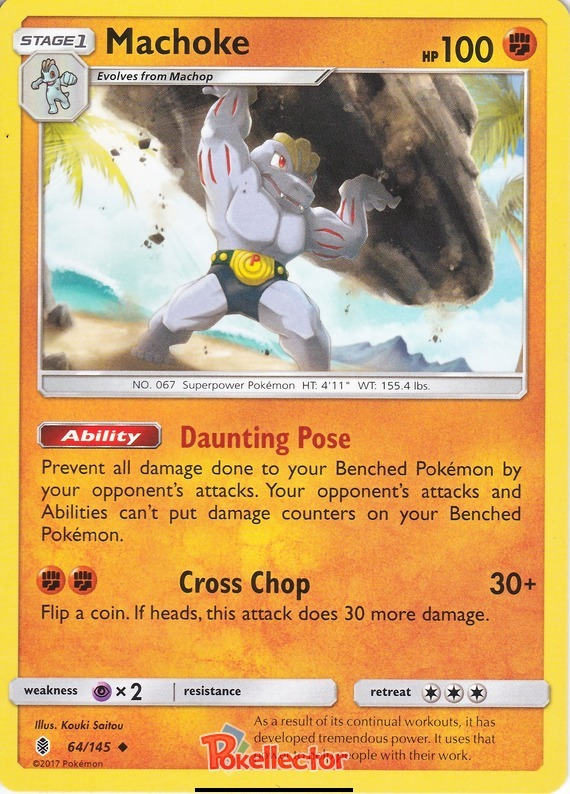

In [119]:
print(base_label)
open_image(base_image)

In [120]:
similar_images_df

img_path    label  label_id  \
1000  /home/subhaditya/Desktop/Datasets/pokemon/Mach...  Machoke        17   
972   /home/subhaditya/Desktop/Datasets/pokemon/Mach...  Machoke        17   
994   /home/subhaditya/Desktop/Datasets/pokemon/Mach...  Machoke        17   
982   /home/subhaditya/Desktop/Datasets/pokemon/Mach...  Machoke        17   
1011  /home/subhaditya/Desktop/Datasets/pokemon/Mach...  Machoke        17   
988   /home/subhaditya/Desktop/Datasets/pokemon/Mach...  Machoke        17   
975   /home/subhaditya/Desktop/Datasets/pokemon/Mach...  Machoke        17   
979   /home/subhaditya/Desktop/Datasets/pokemon/Mach...  Machoke        17   

                                               img_repr  
1000  [-13.2265625, 44.46875, -34.8125, -0.733886718...  
972   [-20.625, 61.375, -28.96875, -12.953125, -9.02...  
994   [3.41796875, 35.65625, -23.734375, -9.078125, ...  
982   [-2.865234375, 42.84375, -27.53125, -11.945312...  
1011  [-16.140625, 62.625, -30.390625, 3.529296875, ...  
988   [-22.796875, 52.25, -45.78125, -4.53125, -12.7...  
975   [-36.875, 54.1875, -29.890625, -14.8125, -10.6...  
979   [-34.15625, 44.84375, -23.046875, -7.6015625, ...

In [121]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df["img_path"]]
    categories = [
        learn.data.train_ds.y.reconstruct(y) for y in similar_images_df["label_id"]
    ]
    return learn.data.show_xys(images, categories)

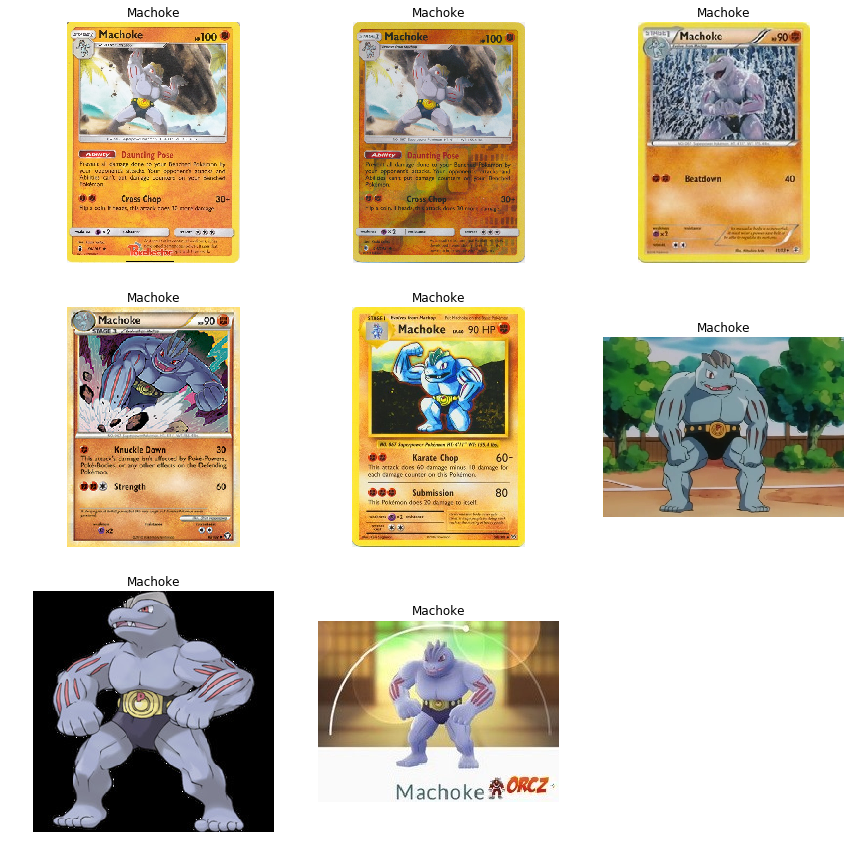

In [122]:
show_similar_images(similar_images_df)

In [113]:
from scipy.spatial.distance import cosine


def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label = df_new.iloc[img_index, [0, 3, 1]]
    cosine_similarity = 1 - df_new["img_repr"].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f"{end - start} secs")
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [127]:
base_image, base_label, similar_images_df = get_similar_images(500)

0.35237908363342285 secs


Bulbasaur
/home/subhaditya/Desktop/Datasets/pokemon/Bulbasaur/00000094.jpg


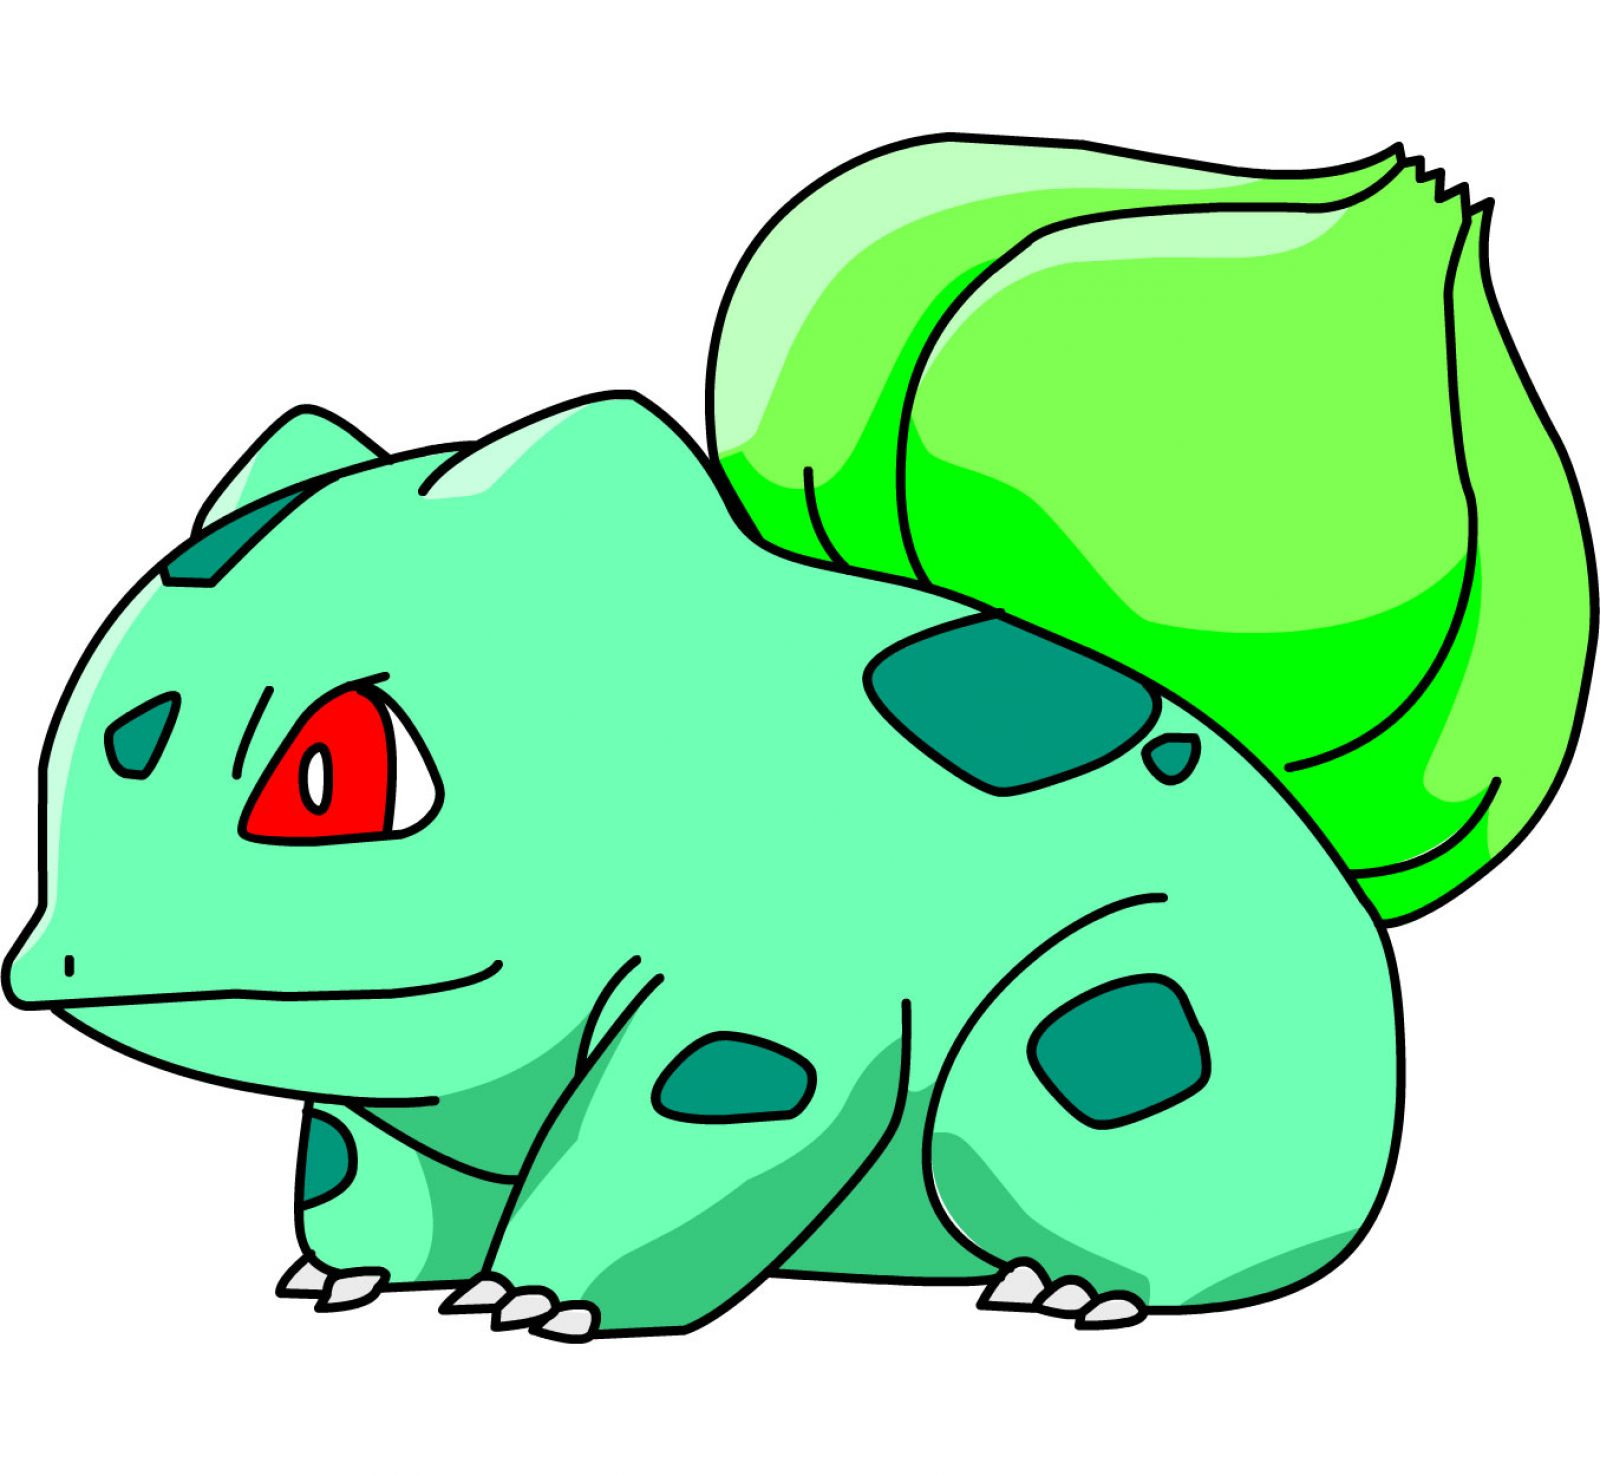

In [128]:
print(base_label)
print(base_image)
open_image(base_image)

In [129]:
similar_images_df

img_path      label  label_id  \
500   /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
5932  /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
496   /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
4867  /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
562   /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
5007  /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
645   /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
555   /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
4813  /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   
624   /home/subhaditya/Desktop/Datasets/pokemon/Bulb...  Bulbasaur         9   

                                               img_repr  
500   [-17.4375, -29.296875, -7.5703125, 12.0078125,...  
5932  [-22.109375, -25.53125, -2.654296875, 10.32812...  
496   [-22.109375, -25.53125, -2.646484375, 10.33593...  
4867  [-20.71875, -9.9296875, 1.3486328125, 11.60937...  
562   [-23.3125, -22.125, -11.1328125, 10.140625, 5....  
5007  [-23.3125, -22.125, -11.1328125, 10.140625, 5....  
645   [-24.921875, -20.546875, 1.2353515625, 15.6875...  
555   [-24.515625, 1.0966796875, -12.2265625, 10.382...  
4813  [-24.515625, 1.0966796875, -12.2265625, 10.382...  
624   [-19.96875, -25.375, 22.765625, 13.9609375, 1....

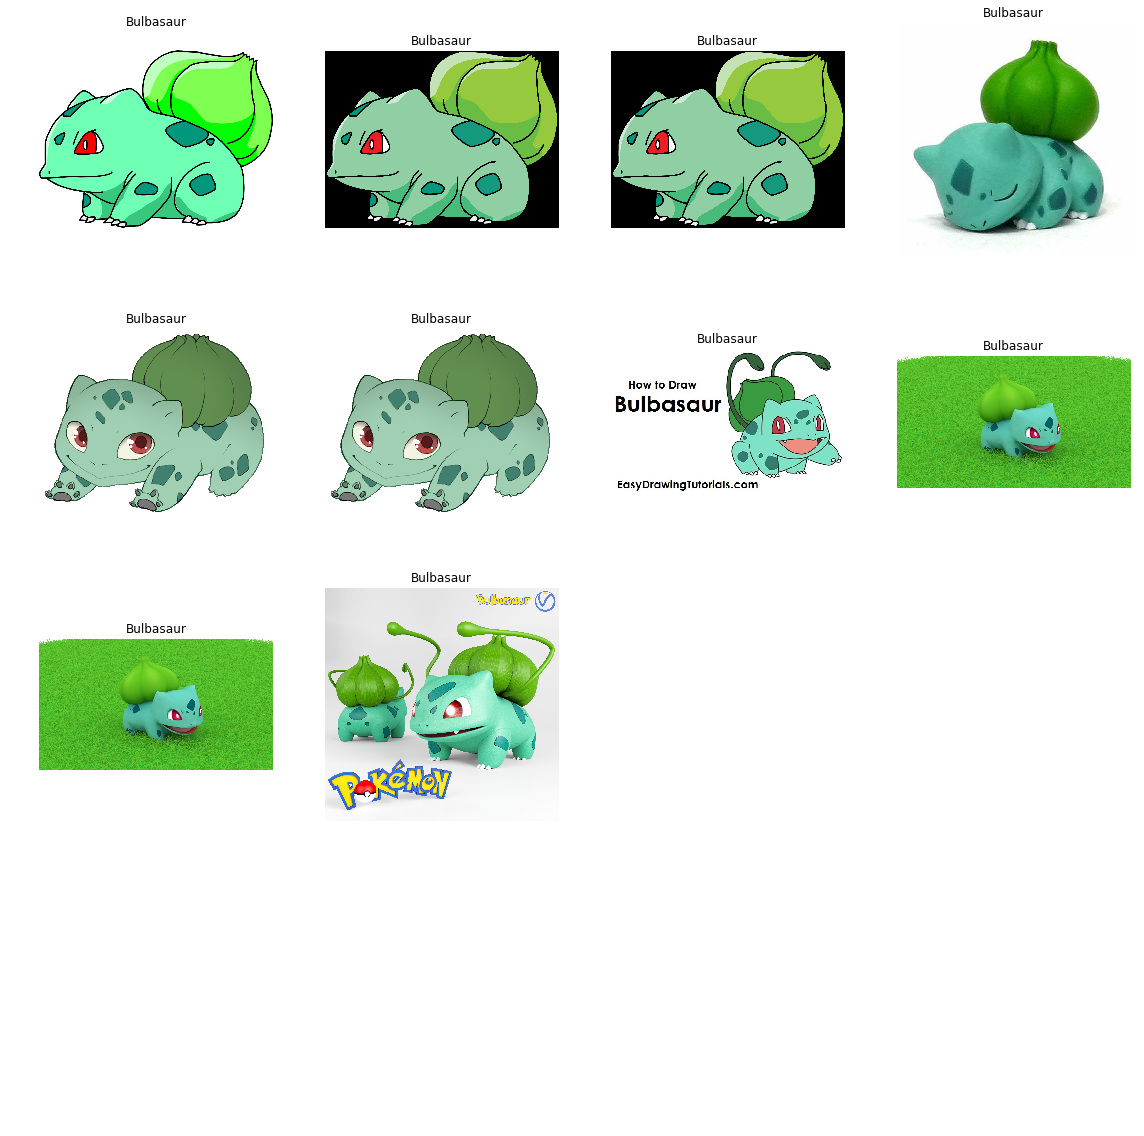

In [130]:
show_similar_images(similar_images_df)